# Breast cancer clustering project
## Primary researchers: Askandar Iqbal, Shumaila Siddiqui
## Secondary researchers: Sriram Chandrasekaran, Kirk Smith (Notebook author)

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import openpyxl
from sklearn import preprocessing
import os
import shap
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
import importlib
import pickle
import myFunctions
import breastCancerFunctions
np.random.seed(123)

### Import data

In [2]:
df_discovery = pd.read_csv("../data/discovery_geneExpr_metabolicOnly.csv")
df_validation = pd.read_csv("../data/validation_geneExpr_metabolicOnly.csv")
df_TCGA = pd.read_csv("../data/TCGA_geneExpr_metabolicOnly.csv")
# df_normal = pd.read_excel("../data/gene_expression_data_MetabolicOnly.xlsx",
#                              sheet_name="Normal data",
#                              usecols="A:BBP")
df_cl = pd.read_csv("../data/cellLine_geneExpression.csv")


# save data to pickle
# PIK = "pickle.dat"
# data = [df_discovery, df_validation, df_TCGA, df_cl]
# with open(PIK, "wb") as f:
#     pickle.dump(data, f)

# # load data via pickle
# PIK = 'pickle.dat'
# with open(PIK, "rb") as f:
#     pik_list = pickle.load(f)

# df_discovery = pik_list[0]
# df_validation = pik_list[1]
# df_TCGA = pik_list[2]
# df_cl = pik_list[3]


### Variable setup

In [3]:
class_names = ["M1","M2","M3"]
num_class=3

## get overlapping genes between expressionsion and cell line (CL) datasets
# first transpose CL data
df_CL = df_cl.set_index('Cell line').T
matching_genes = df_CL.iloc[:,df_CL.columns.isin(df_discovery.columns)].columns.tolist()
# print(matching_genes)
new_columns = matching_genes+["Metabolic cluster"]
print("Number matching genes: {} \n".format(len(matching_genes)))

# update datasets to include matching genes only
# (since we will be making predictions on cell line data, can only build model with overlapping genes)
df_discovery = df_discovery.loc[:,new_columns]
df_validation = df_validation.loc[:,new_columns]
df_TCGA = df_TCGA.loc[:,new_columns]
df_CL = df_CL.loc[:,matching_genes]

# numerically encode cluster labels
le = preprocessing.LabelEncoder()
y_disc = pd.Series(le.fit_transform(df_discovery['Metabolic cluster']))

# standardize feature data
std_scaler = StandardScaler()
X_disc_sc = std_scaler.fit_transform(df_discovery[matching_genes])

## create folder to save figures
path = "./notebook_figures/"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
# set font type
pltFont = {'fontname':'Arial'}

Number matching genes: 1330 

Creation of the directory ./notebook_figures/ failed


In [4]:
print(df_discovery[matching_genes].shape)
print(df_validation[matching_genes].shape)
print(df_TCGA[matching_genes].shape)

(993, 1330)
(994, 1330)
(1087, 1330)


### Test different machine-learning algorithms for classifying metabolic clusters using gene expression data
**LR** = logistic regression; **Ridge** = ridge regression; **XGB** = XGBoost; **KNN** = K-nearest Neighbors; **DT** = decision tree; **AB** = AdaBoost; **RF** = random forest; **BRF** = balanced random forest; **SVM** = Support vector machine clustering, **NC** = Nearest centroid clustering

In [5]:
importlib.reload(breastCancerFunctions)

<module 'breastCancerFunctions' from 'C:\\Users\\kirksmi\\Documents\\sriramLab_projects\\breastCancerProject\\code\\breastCancerFunctions.py'>

Showing average and std. dev. of F1 scores from 5-fold cross validation...
LR: 0.910233 (0.020479)
Ridge: 0.908765 (0.022911)
DT: 0.775897 (0.021743)
AB: 0.859714 (0.044783)
RF: 0.881104 (0.026115)
XGB: 0.890880 (0.014323)
BRF: 0.884487 (0.021711)
KNN: 0.803580 (0.021770)
SVM: 0.889120 (0.005340)
NC: 0.894684 (0.020534)


FixedFormatter should only be used together with FixedLocator


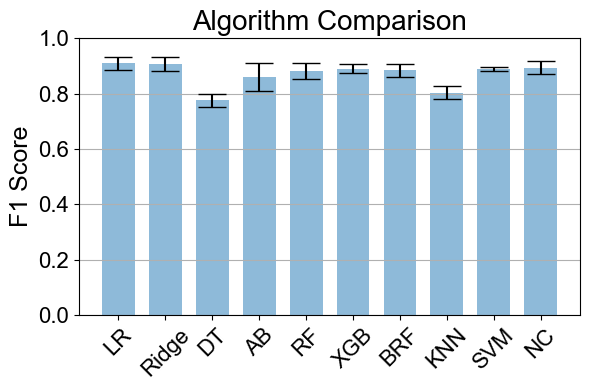

In [51]:
# unscaled data
test_scores_unsc = breastCancerFunctions.testAlgorgithms(X = df_discovery[matching_genes],
                                      y = y_disc,
                                      condition = "discovery_geneExpr_unscaled",
                                      path = path)

In [24]:
df_discovery[matching_genes].shape
np.logspace(-3,3,10)

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])

### Train models
Will try logistic regression (best performing) and nearest centroid (best clustering algorithm)

Creation of the directory ./notebook_figures/tuneModels_230112 failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


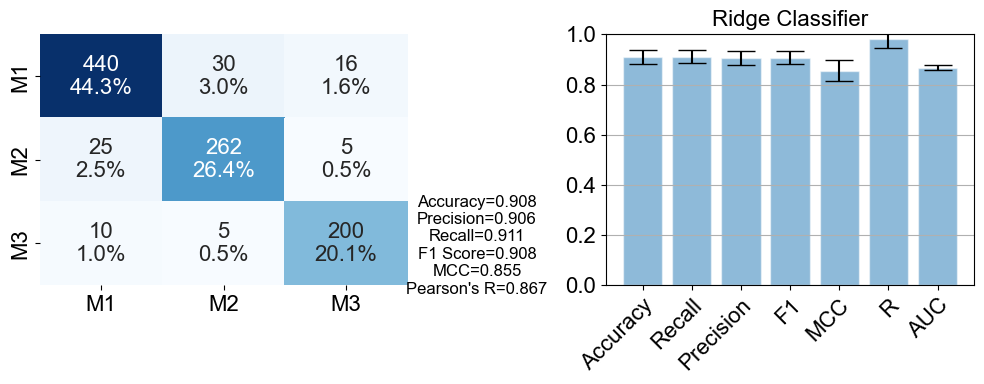

In [6]:
# train and validate 
# path = "final_figures/"
importlib.reload(breastCancerFunctions)
tune_mdls_path = path+"tuneModels_230112"

ridge_mdl = breastCancerFunctions.tuneModels(X = df_discovery[matching_genes],
                                         y = df_discovery['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="Ridge_nonsc",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=True,
                                         weight=True)


### Validate both models on Validation and TCGA

Creation of the directory ./notebook_figures//validation_230112 failed

 Ridge_unsc 

NO SCALING!


<Figure size 640x480 with 0 Axes>

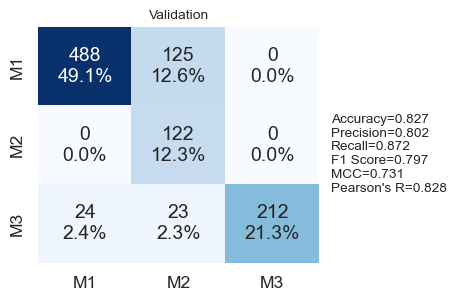

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


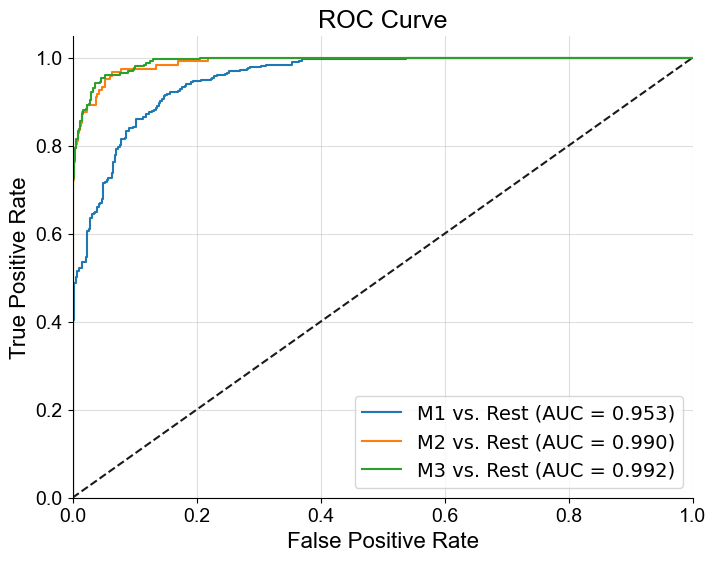

NO SCALING!


<Figure size 640x480 with 0 Axes>

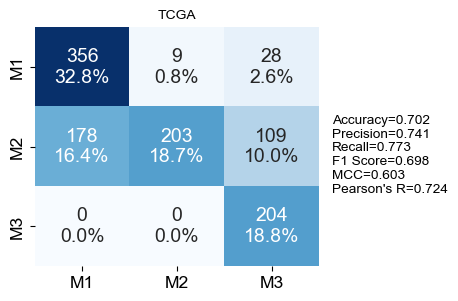

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


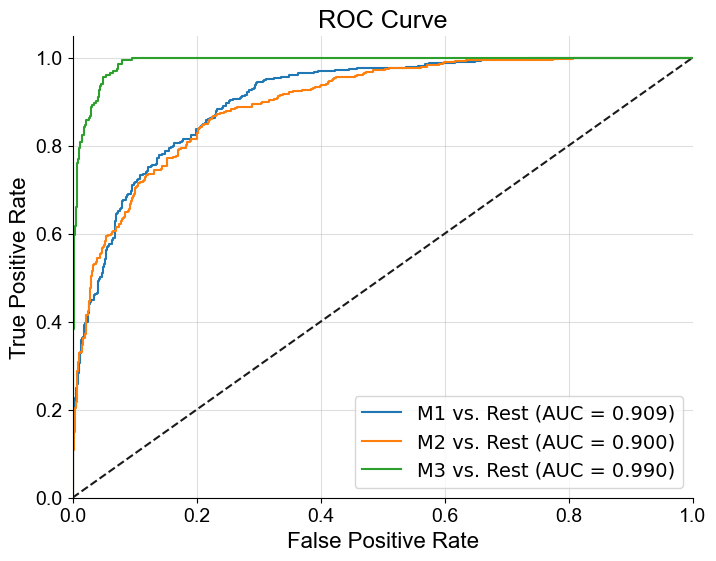

In [7]:
importlib.reload(breastCancerFunctions)
# path="./final_figures"
# try:
#     os.mkdir(path)
# except OSError:
#     print ("Creation of the directory %s failed" % path)
# else:
#     print ("Successfully created the directory %s " % path)
    
val_path = path+"/validation_230112"

X_train = df_discovery[matching_genes]
y_train = pd.Series(le.fit_transform(df_discovery['Metabolic cluster']))

ridge_validate = breastCancerFunctions.modelValidation(ridge_mdl,
                X_vals=[df_validation[matching_genes], df_TCGA[matching_genes]],
                y_vals=[df_validation['Metabolic cluster'], df_TCGA['Metabolic cluster']],
                val_IDs=["Validation","TCGA"],
                condition="Ridge_unsc",
                class_names=class_names,
                path=val_path,
                scale="none",
                X_train = X_train, y_train = y_train)


## Cell line analysis
### Compare gene expression between Metabric/TCGA and cell line datasets
### Without scaling:

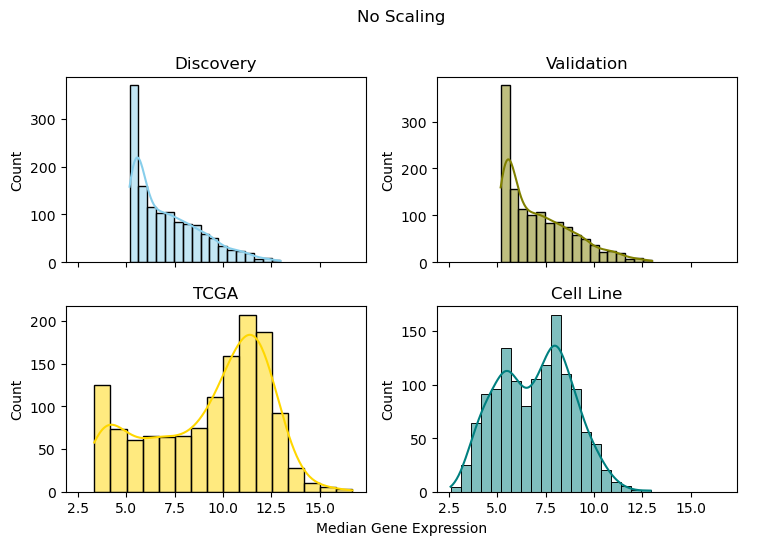

In [9]:
# before scaling
fig, axs = plt.subplots(2, 2, figsize=(8,6),sharex=True)

sns.histplot(data=np.median(df_discovery[matching_genes], axis=0), kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=np.median(df_validation[matching_genes], axis=0), kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=np.median(df_TCGA[matching_genes], axis=0), kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=np.median(df_CL[matching_genes], axis=0), kde=True, color="teal", ax=axs[1, 1])
axs[0, 0].set_title("Discovery")
# axs[0, 0].set_xlim(0,20)
axs[0, 1].set_title("Validation")
# axs[0, 1].set_xlim(0,20)
axs[1, 0].set_title("TCGA")
# axs[1, 1].set_xlim(0,20)
axs[1, 1].set_title("Cell Line")
# axs[1, 1].set_xlim(0,20)

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Median Gene Expression")
plt.title('No Scaling', pad=40)
plt.tight_layout()
# plt.savefig('./figures/cellLine_geneExpr_histo.png', bbox_inches='tight', dpi=600)
plt.show()

### Let's also train models using Validation and TCGA

Creation of the directory ./notebook_figures/tuneModels_230112 failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


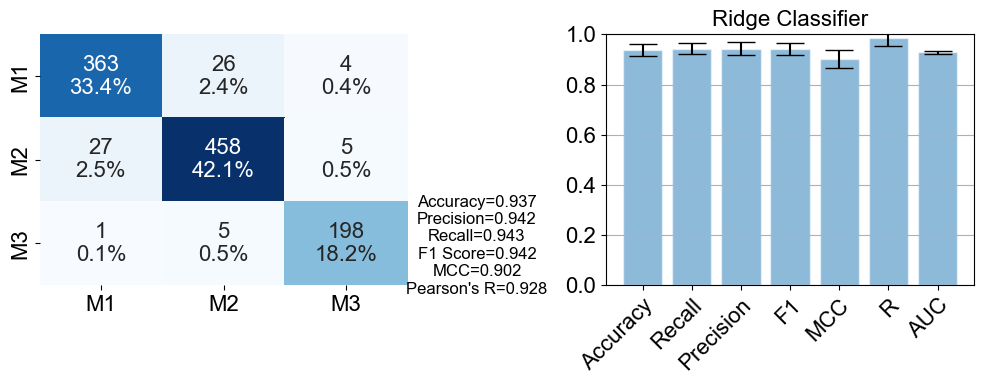

Creation of the directory ./notebook_figures/tuneModels_230112 failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


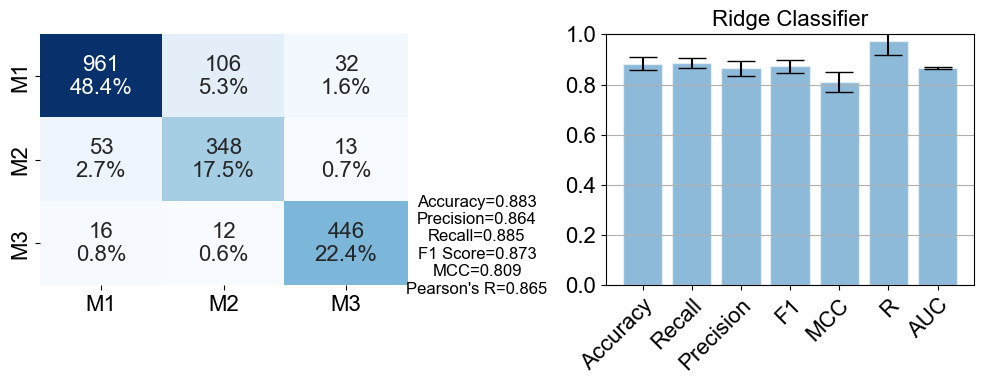

In [10]:
ridge_tcga_mdl = breastCancerFunctions.tuneModels(X = df_TCGA[matching_genes],
                                         y = df_TCGA['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="Ridge_unsc_TCGA",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=True,
                                         weight=True)

# ridge_val_mdl = breastCancerFunctions.tuneModels(X = df_validation[matching_genes],
#                                          y = df_validation['Metabolic cluster'],
#                                          model_name = "Ridge",
#                                          condition="Ridge_unsc_val",
#                                          path=tune_mdls_path,
#                                          class_names = class_names,
#                                          scale = "none",
#                                          tune=True,
#                                          weight=True)

df_metabric = pd.concat([df_discovery, df_validation], axis=0)
ridge_metabric_mdl = breastCancerFunctions.tuneModels(X = df_metabric[matching_genes],
                                         y = df_metabric['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="Ridge_unsc_metabric",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=True,
                                         weight=True)


### Now make predictions on the cell line data

<Figure size 800x600 with 0 Axes>

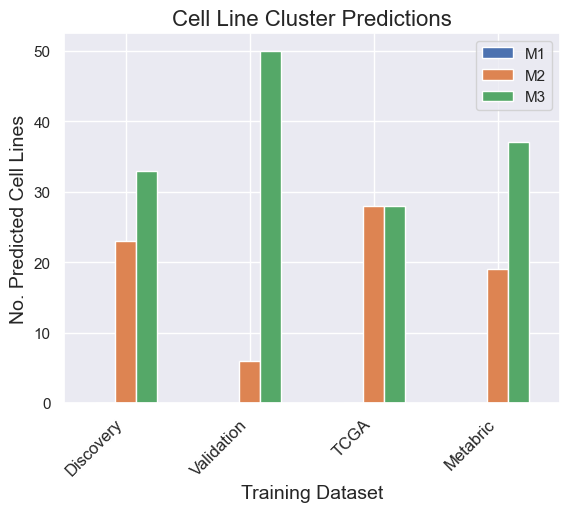

In [57]:
X_test = df_CL[matching_genes]

df_pred_sums = pd.DataFrame(columns = ['M1', 'M2', 'M3'])
df_pred = pd.DataFrame(df_CL.index, columns=["Cell_Line"])

my_models = ["Discovery","Validation","TCGA", "Metabric"]
for model, name in zip([ridge_mdl, ridge_val_mdl, ridge_tcga_mdl, ridge_metabric_mdl],
                       my_models):
    # make predictions
    y_pred = model.predict(X_test)

    # count number of predictions per class
    # print(Counter(y_pred))    
    cluster_labels = np.where(y_pred==0,"M1",
                              np.where(y_pred==1, "M2", "M3"))
    df_pred[name] = pd.DataFrame(cluster_labels)

    df_pred_sums = df_pred_sums.append({'M1' : sum(y_pred==0), 'M2' : sum(y_pred==1), 'M3' : sum(y_pred==2)}, 
            ignore_index = True)
    
all_m1 = sum(df_pred.iloc[:,1:5].eq("M1").all(axis=1))
all_m2 = sum(df_pred.iloc[:,1:5].eq("M2").all(axis=1))
all_m3 = sum(df_pred.iloc[:,1:5].eq("M3").all(axis=1))

# my_percents = np.zeros((4,3))
# for (index, row) in df_pred_sums.iterrows():
#     my_percents[index] = [all_m1, all_m2, all_m3] / row

# plot results
plt.figure(figsize=(8,6))
ax = df_pred_sums.plot.bar()
plt.xticks(np.arange(0,len(my_models)), my_models, rotation=45, ha='right', fontsize=12)
plt.ylabel("No. Predicted Cell Lines", fontsize=14)
plt.xlabel("Training Dataset",fontsize=14)
plt.title("Cell Line Cluster Predictions", fontsize=16)
# for i, p in enumerate(ax.patches):
#     ax.annotate("{:.0%}".format(my_percents.T.reshape(-1)[i]), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig(path+'./CellLinePredictions_barGraph_221018.png',
                bbox_inches='tight', dpi=600)
plt.show()



### Show METBARIC and TCGA only

<Figure size 800x600 with 0 Axes>

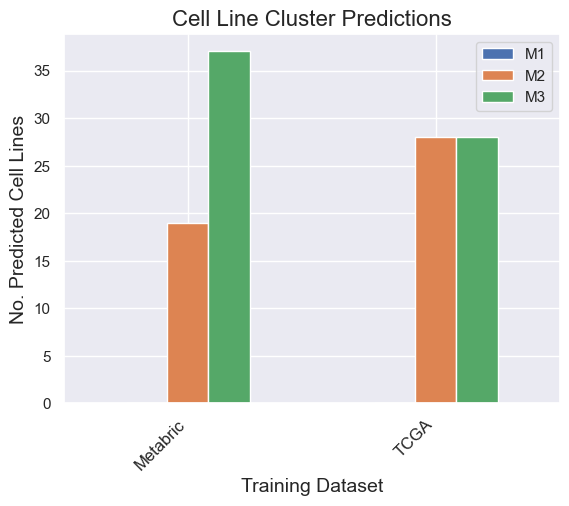

In [60]:
X_test = df_CL[matching_genes]

df_pred_sums = pd.DataFrame(columns = ['M1', 'M2', 'M3'])
df_pred = pd.DataFrame(df_CL.index, columns=["Cell_Line"])

my_models = ["Metabric", "TCGA"]
for model, name in zip([ridge_metabric_mdl, ridge_tcga_mdl],
                       my_models):
    # make predictions
    y_pred = model.predict(X_test)

    # count number of predictions per class
    # print(Counter(y_pred))    
    cluster_labels = np.where(y_pred==0,"M1",
                              np.where(y_pred==1, "M2", "M3"))
    df_pred[name] = pd.DataFrame(cluster_labels)

    df_pred_sums = df_pred_sums.append({'M1' : sum(y_pred==0), 'M2' : sum(y_pred==1), 'M3' : sum(y_pred==2)}, 
            ignore_index = True)

# plot results
plt.figure(figsize=(8,6))
ax = df_pred_sums.plot.bar()
plt.xticks(np.arange(0,len(my_models)), my_models, rotation=45, ha='right', fontsize=12)
plt.ylabel("No. Predicted Cell Lines", fontsize=14)
plt.xlabel("Training Dataset",fontsize=14)
plt.title("Cell Line Cluster Predictions", fontsize=16)
plt.savefig(path+'./CellLinePredictions_barGraph.png',
                bbox_inches='tight', dpi=600)
plt.show()

In [14]:
df_pred.to_csv("cellLine_prediction_221012.csv", index=False)

In [61]:
path

'./notebook_figures/'

### Make predictions on new expression data

In [41]:
# with open('../data/my_genes.txt', 'w') as f:
#     for line in matching_genes:
#         f.write(f"{line}\n")

df_new = pd.read_csv("../data/new_expression_processed_kirk.csv",index_col=0)
df_new.head()

,A4GALT,A4GNT,AACS,AADAC,AADAT,AASS,ABAT,ABCA1,ABCB11,ABCB4,...,UROC1,UROD,UROS,UST,UXS1,XDH,XYLB,XYLT1,XYLT2,ZADH2
Gene_symbol,,,,,,,,,,,,,,,,,,,,,
GSM927010,7.340080,4.632591,7.524723,3.531451,7.248041,8.278250,8.158648,8.693750,3.798949,5.212178,...,5.688963,8.564296,8.137341,7.365032,7.781500,5.850316,8.385818,8.220541,7.554043,8.854045
GSM927011,6.666730,4.310933,7.378439,3.465636,6.904514,7.553850,7.269407,8.518094,3.915779,5.814910,...,5.375390,8.457556,8.676508,7.102390,8.620211,7.356236,9.019237,7.880705,7.535245,9.081578
GSM927012,7.356544,4.629741,7.353973,3.498158,6.680895,8.027652,7.429675,8.632614,4.080810,5.501578,...,6.110408,8.546052,7.772388,7.034689,7.948101,6.849992,7.987931,8.421595,7.465611,8.309716
GSM927013,7.138639,4.644497,8.087758,3.537567,7.385795,7.642068,7.523777,8.370300,3.843064,5.228505,...,5.631780,8.582289,7.959821,7.443730,7.797587,7.228945,8.758479,8.530263,7.529395,8.723019
GSM927014,7.040386,4.635956,7.505915,3.532022,7.401858,7.113262,7.360538,8.816367,3.896633,5.535449,...,5.987164,8.295454,8.384851,6.630572,7.847609,5.576164,8.743406,8.785497,7.893600,8.437771


Creation of the directory ./notebook_figures/tuneModels_221025 failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


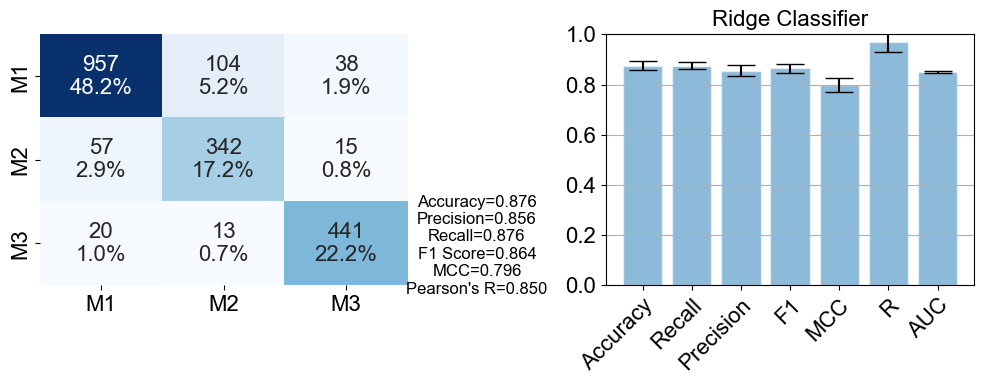

In [29]:
matching_genes_new = df_new.iloc[:,df_new.columns.isin(df_discovery.columns)].columns.tolist()
len(matching_genes_new)

df_metabric = pd.concat([df_discovery, df_validation], axis=0)

ridge_mdl_new = breastCancerFunctions.tuneModels(X = df_metabric[matching_genes_new],
                                         y = df_metabric['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="Ridge_nonsc_new",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=True,
                                         weight=True)

Creation of the directory ./notebook_figures//validation_221124 failed

 Ridge_unsc_new 

NO SCALING!


<Figure size 640x480 with 0 Axes>

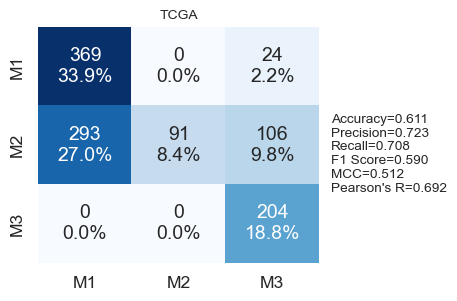

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


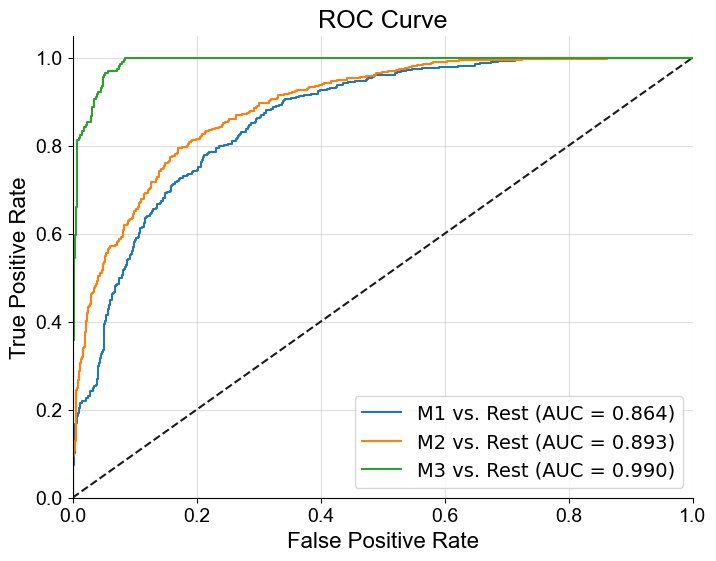

In [31]:
X_train_new = df_metabric[matching_genes_new]
y_train_new = pd.Series(le.fit_transform(df_metabric['Metabolic cluster']))
val_path = path+"/validation_221124"

ridge_new_validate = breastCancerFunctions.modelValidation(ridge_mdl_new,
                X_vals=[df_TCGA[matching_genes_new]],
                y_vals=[df_TCGA['Metabolic cluster']],
                val_IDs=["TCGA"],
                condition="Ridge_unsc_new",
                class_names=class_names,
                path=val_path,
                scale="none",
                X_train = X_train_new,
                y_train = y_train_new)


In [45]:
 # make predictions
X_test = df_new[matching_genes_new]
y_pred_new = ridge_mdl_new.predict(X_test)

# count number of predictions per class
# print(Counter(y_pred))    
cluster_labels = np.where(y_pred_new==0,"M1",
                          np.where(y_pred_new==1, "M2", "M3"))
df_predict_new = pd.DataFrame({'SubjectID':df_new.index, 'predictions':cluster_labels})
df_predict_new.to_csv("new_prediction_results.csv")

In [46]:
print(len(matching_genes))
print(len(matching_genes_new))

1330
1273


## Shapley analysis

In [13]:
from copy import deepcopy

X_train = df_discovery[matching_genes]
X_test = df_validation[matching_genes]

clf = deepcopy(ridge_mdl)
explainer = shap.LinearExplainer(clf, X_train)
shap_explainer = explainer(X_test) 
shap_values = explainer.shap_values(X_test)

# # compute SHAP values
# explainer = shap.Explainer(clf)
# shap_values = explainer(X_train)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Successfully created the directory ./notebook_figures/SHAP_230112 


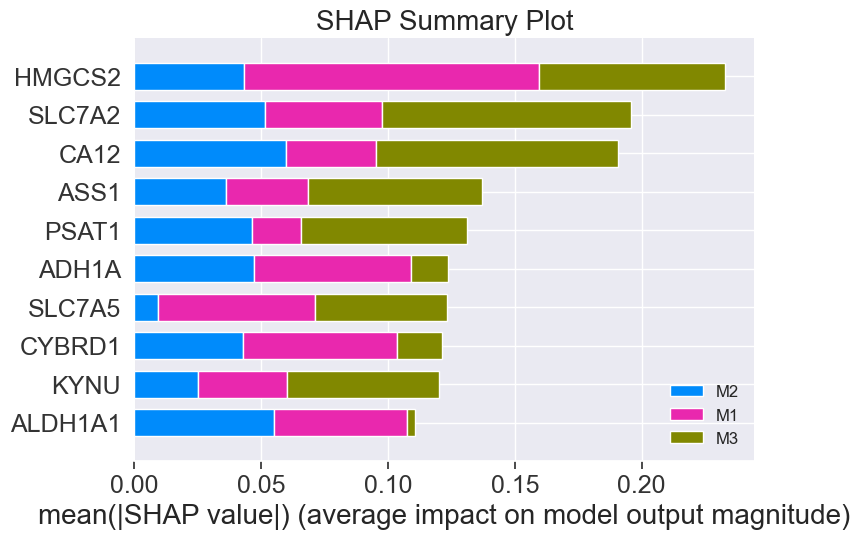

In [14]:
# combined summary 
    
shap_path="./notebook_figures/SHAP_230112"
try:
    os.mkdir(shap_path)
except OSError:
    print ("Creation of the directory %s failed" % shap_path)
else:
    print ("Successfully created the directory %s " % shap_path)

condition = "Discovery"
plt.figure(figsize=(4,4))
shap.summary_plot(shap_values, X_test, class_names=class_names, max_display=10, show=False) #class_names = multi_classes
plt.title("SHAP Summary Plot", fontsize=20, **pltFont)
plt.yticks(fontsize=18, **pltFont)
plt.xticks(fontsize=18, **pltFont)
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)",
           fontsize=20, **pltFont)
plt.savefig(shap_path+"/{}_MultiSummaryPlot.png".format(condition),
             bbox_inches='tight', dpi=600)
plt.show()


### Individual summary plots

Current class:  0


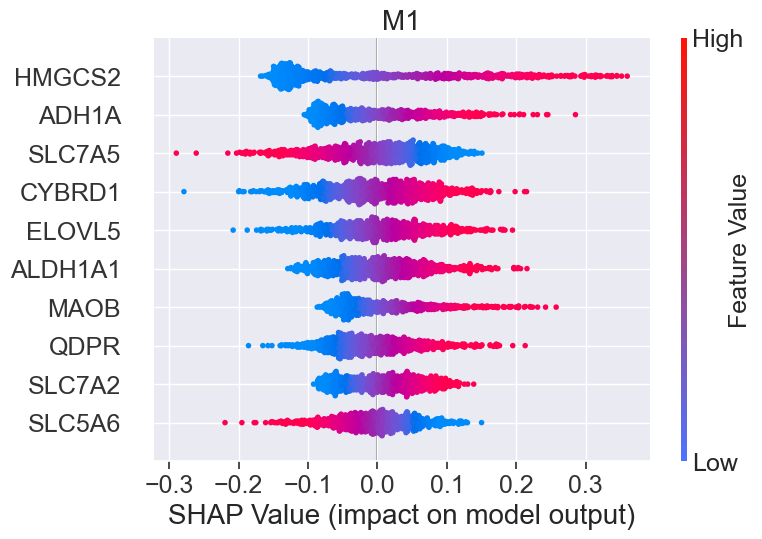

Current class:  1


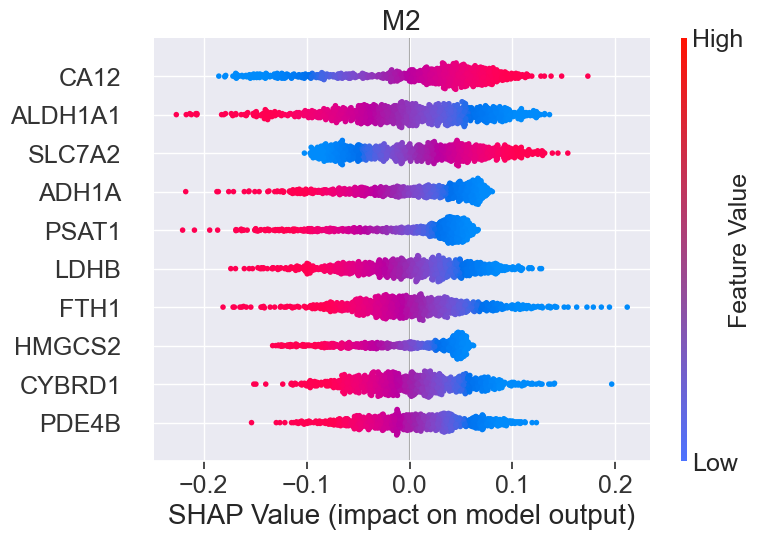

Current class:  2


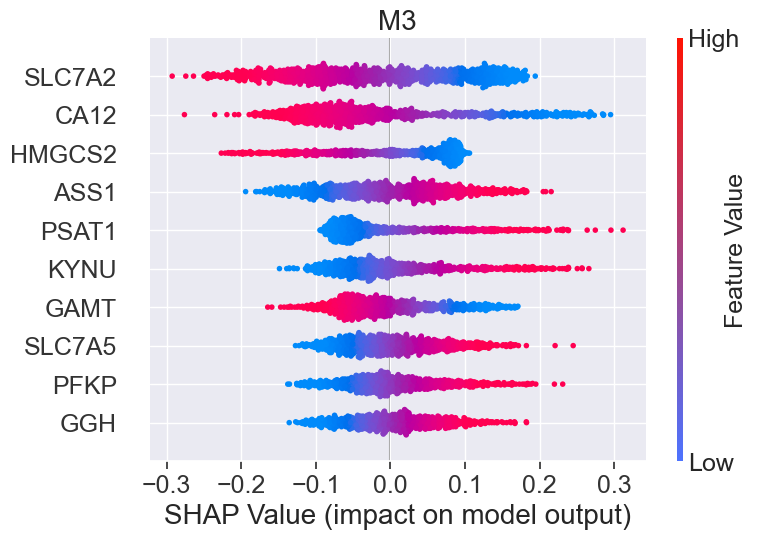

In [15]:
import matplotlib.colors as mcol
import matplotlib.cm as pltcm

for which_class in range(num_class):
    print("Current class: ", which_class)

    # summary single class
    plt.figure(figsize=(4,4))
    shap.summary_plot(shap_values[which_class], X_test, max_display=10,
                      color_bar=False, show=False)
    plt.title("{}".format(class_names[which_class]),fontsize=20, **pltFont)
    plt.yticks(fontsize=18, **pltFont)
    plt.xticks(fontsize=18, **pltFont)
    plt.xlabel("SHAP Value (impact on model output)",fontsize=20, **pltFont)
    # make our own color bar so that we can adjust font/label sizes
    cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["#4d73ff","#ff1303"])
    cnorm = mcol.Normalize(vmin=0,vmax=1)
    m = pltcm.ScalarMappable(norm=cnorm,cmap=cm1)
    m.set_array([0, 1])
    cb = plt.colorbar(m, ticks=[0, 1], aspect=1000)
    cb.set_ticklabels(["Low", "High"])
    cb.set_label("Feature Value", size=18, labelpad=-10)
    cb.ax.tick_params(labelsize=18, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)
    bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
    cb.ax.set_aspect((bbox.height - 0.9) * 20)
    plt.savefig(shap_path+"/{}_SingleSummaryPlot.png".format(class_names[which_class]),
                  dpi=600, bbox_inches='tight')
    plt.show()

In [10]:
# save list of SHAP genes to Excel
vals= np.abs(shap_values).mean(0)
shap_importance = pd.DataFrame(list(zip(X_test.columns, sum(vals))),
                                  columns=['gene','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                                ascending=False,inplace=True)
shap_importance[0:50].to_csv(shap_path+'/Discovery_Top50_ShapValues.csv',
      index=False)  

top_genes = list(shap_importance.gene[0:50])
print(len(top_genes))

50


### Train models using top 50 genes from SHAP analysis

./notebook_figures/tuneModels_221012
Creation of the directory ./notebook_figures/tuneModels_221012 failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


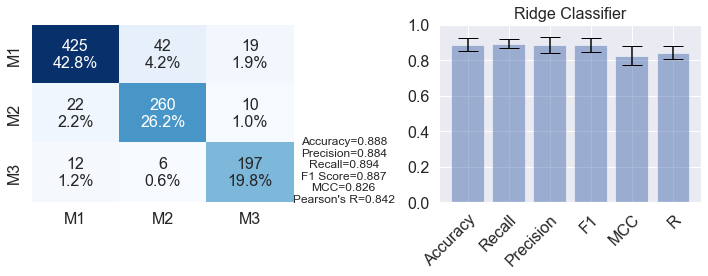

Creation of the directory ./notebook_figures/tuneModels_221012 failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


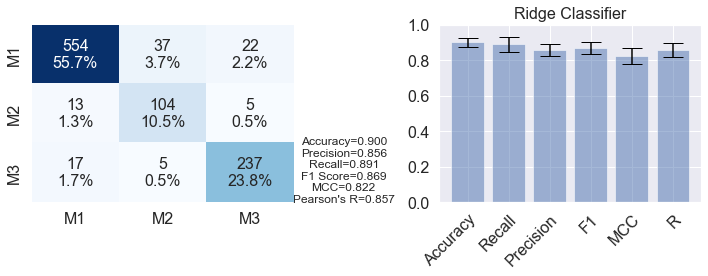

Creation of the directory ./notebook_figures/tuneModels_221012 failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


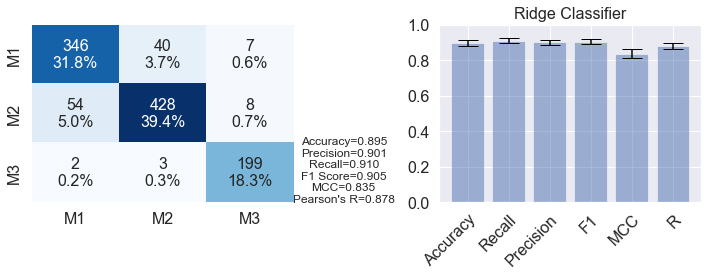

Creation of the directory ./notebook_figures/tuneModels_221012 failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits
NO FEATURE SCALING!
TUNING MODEL!
Fitting 5 folds for each of 5 candidates, totalling 25 fits


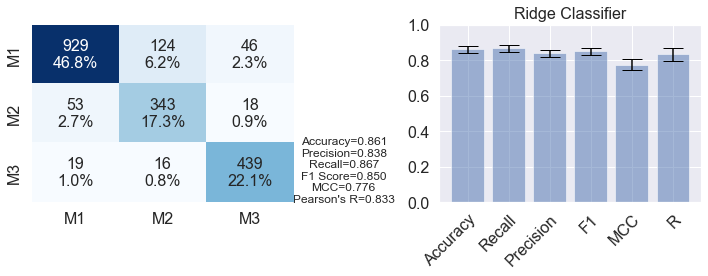

In [11]:
print(tune_mdls_path)
ridge50_disc_mdl = breastCancerFunctions.tuneModels(X = df_discovery[top_genes],
                                         y = df_discovery['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="ridge_top50_disc",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=True,
                                         weight=True)

ridge50_val_mdl = breastCancerFunctions.tuneModels(X = df_validation[top_genes],
                                         y = df_validation['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="ridge_top50_val",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=True,
                                         weight=True)

ridge50_tcga_mdl = breastCancerFunctions.tuneModels(X = df_TCGA[top_genes],
                                         y = df_TCGA['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="ridge_top50_tcga",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=True,
                                         weight=True)

ridge50_metabric_mdl = breastCancerFunctions.tuneModels(X = df_metabric[top_genes],
                                         y = df_metabric['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition = "ridge_top50_metabric",
                                         path = tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune = True,
                                         weight = True)

Successfully created the directory ./notebook_figures//validation_221018 

 Ridge_top50_disc 

NO SCALING!


<Figure size 432x288 with 0 Axes>

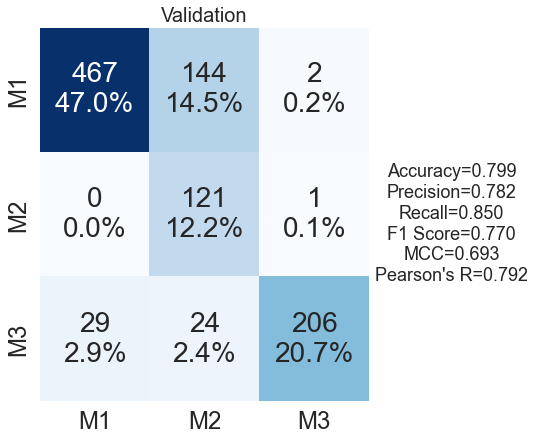

NO SCALING!


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<Figure size 432x288 with 0 Axes>

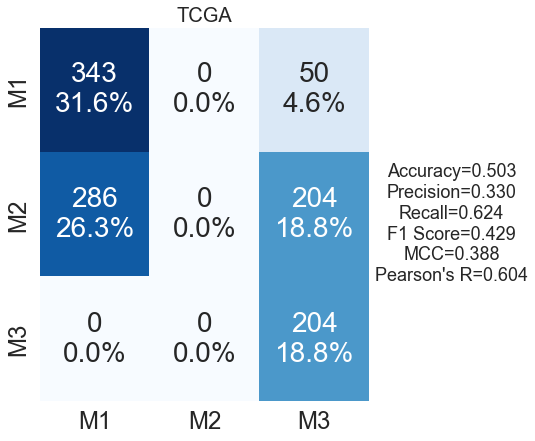

Creation of the directory ./notebook_figures//validation_221018 failed

 Ridge_top50_metabric 

NO SCALING!


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


<Figure size 432x288 with 0 Axes>

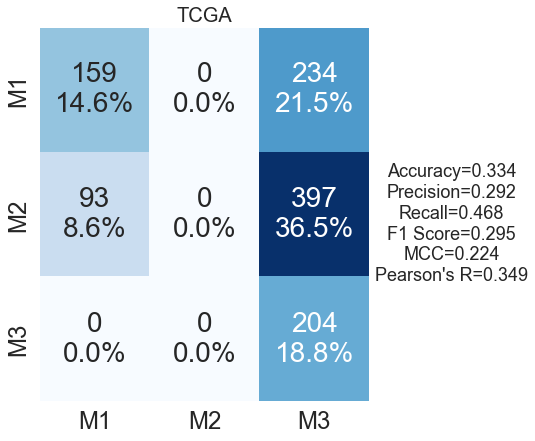

In [13]:
val_path = path+"/validation_221018"

ridge50_validate = breastCancerFunctions.modelValidation(ridge50_disc_mdl,
                X_vals=[df_validation[top_genes], df_TCGA[top_genes]],
                y_vals=[df_validation['Metabolic cluster'], df_TCGA['Metabolic cluster']],
                val_IDs=["Validation","TCGA"],
                condition="Ridge_top50_disc",
                class_names=class_names,
                path=val_path,
                scale="none")

ridge50_validate_metabric = breastCancerFunctions.modelValidation(ridge50_metabric_mdl,
                X_vals=[df_TCGA[top_genes]],
                y_vals=[df_TCGA['Metabolic cluster']],
                val_IDs=["TCGA"],
                condition="Ridge_top50_metabric",
                class_names=class_names,
                path=val_path,
                scale="none")


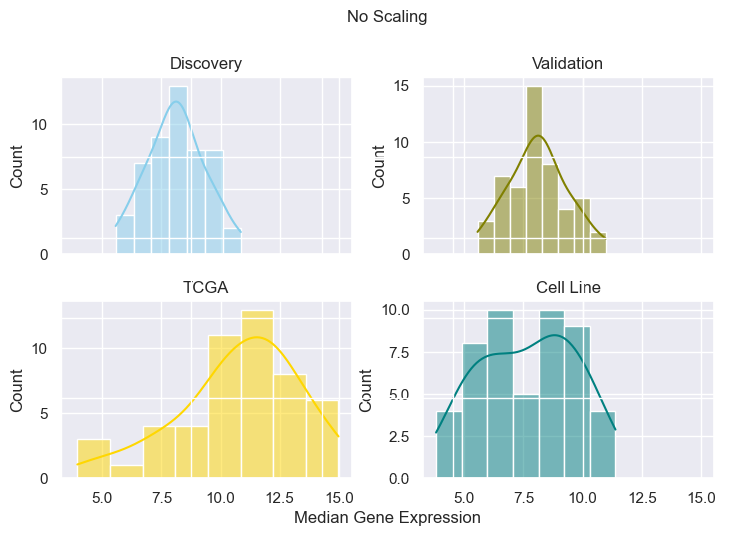

In [189]:
# before scaling
fig, axs = plt.subplots(2, 2, figsize=(8,6),sharex=True)

sns.histplot(data=np.median(df_discovery[top_genes], axis=0), kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=np.median(df_validation[top_genes], axis=0), kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=np.median(df_TCGA[top_genes], axis=0), kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=np.median(df_CL[top_genes], axis=0), kde=True, color="teal", ax=axs[1, 1])
axs[0, 0].set_title("Discovery")
# axs[0, 0].set_xlim(0,20)
axs[0, 1].set_title("Validation")
# axs[0, 1].set_xlim(0,20)
axs[1, 0].set_title("TCGA")
# axs[1, 1].set_xlim(0,20)
axs[1, 1].set_title("Cell Line")
# axs[1, 1].set_xlim(0,20)

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("Median Gene Expression")
plt.title('No Scaling', pad=40)
plt.tight_layout()
# plt.savefig('./figures/cellLine_geneExpr_histo.png', bbox_inches='tight', dpi=600)
plt.show()

<Figure size 576x432 with 0 Axes>

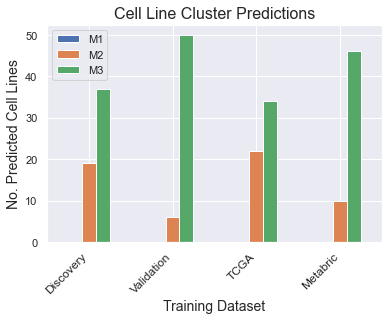

In [17]:
X_test = df_CL[top_genes]

df_pred_sums = pd.DataFrame(columns = ['M1', 'M2', 'M3'])
df_pred_top50 = pd.DataFrame(df_CL.index, columns=["Cell_Line"])

my_models = ["Discovery","Validation","TCGA", "Metabric"]
for model, name in zip([ridge50_disc_mdl, ridge50_val_mdl, ridge50_tcga_mdl, ridge50_metabric_mdl],
                       my_models):
    # make predictions
    y_pred = model.predict(X_test)

    # count number of predictions per class
    # print(Counter(y_pred))    
    cluster_labels = np.where(y_pred==0,"M1",
                              np.where(y_pred==1, "M2", "M3"))
    df_pred_top50[name] = pd.DataFrame(cluster_labels)

    df_pred_sums = df_pred_sums.append({'M1' : sum(y_pred==0), 'M2' : sum(y_pred==1), 'M3' : sum(y_pred==2)}, 
            ignore_index = True)

# plot results
plt.figure(figsize=(8,6))
ax = df_pred_sums.plot.bar()
plt.xticks(np.arange(0,len(my_models)), my_models, rotation=45, ha='right', fontsize=12)
plt.ylabel("No. Predicted Cell Lines", fontsize=14)
plt.xlabel("Training Dataset",fontsize=14)
plt.title("Cell Line Cluster Predictions", fontsize=16)
# for i, p in enumerate(ax.patches):
#     ax.annotate("{:.0%}".format(my_percents.T.reshape(-1)[i]), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig(path+'/CellLinePredictions_top50_barGraph_221018.png',
                bbox_inches='tight', dpi=600)
plt.show()



In [15]:
# df_cellLine_pred = pd.DataFrame({"Cell.Line": df_CL.index,
#                                  "All.Genes":df_pred["Ridge.Discovery"],
#                                  "Top.Genes":df_pred_top50["ridge"]})
# df_cellLine_pred.index = df_CL.index()
# print(df_cellLine_pred)
# print(np.sum(df_cellLine_pred['All.Genes']==df_cellLine_pred['Top.Genes']))
# df_cellLine_pred.head()
# df_cellLine_pred.to_csv("cellLine_predictions.csv",index=False, mode='w')

with pd.ExcelWriter(path+'/cellLine_predictions_221018.xlsx') as writer:  
    df_pred.to_excel(writer, sheet_name='All.Met.Genes',index=False)
    df_pred_top50.to_excel(writer, sheet_name='Top50.Genes',index=False)


## What about using non-metabolic genes for training?
### First, load and format the data

In [23]:
df_discovery_all = pd.read_excel("../data/Metabolic_clusters_gene_expression_data.xlsx",
                                 sheet_name="METABRIC_Discovery set",
                                 usecols="A:ALF")

df_validation_all = pd.read_excel("../data/Metabolic_clusters_gene_expression_data.xlsx",
                                 sheet_name="METABRIC_Validation set",
                                 usecols="A:ALG")
df_tcga_all = pd.read_excel("../data/Metabolic_clusters_gene_expression_data.xlsx",
                                 sheet_name="TCGA set",
                                 usecols="A:AOV")

In [25]:
# genes x subjects
print(np.shape(df_discovery_all))
print(np.shape(df_validation_all))
print(np.shape(df_tcga_all))


(19221, 994)
(19221, 995)
(19584, 1088)


In [26]:
### format discovery (need to transpose)
T_disc_all = df_discovery_all.transpose()
new_header = T_disc_all.iloc[0] #grab the first row for the header
T_disc_all = T_disc_all[1:]  #take the data less the header row
T_disc_all.columns = new_header #set the header row as the df header
y_disc_all = T_disc_all['Metabolic cluster']
all_genes_feats = list(T_disc_all.columns[1:])

T_disc_all = T_disc_all[all_genes_feats].apply(pd.to_numeric, errors='coerce')
T_disc_all['Metabolic cluster'] = y_disc_all
T_disc_all.dropna(inplace=True)

# pickle.dump(T_disc_all, open( "T_disc_all.p", "wb" ) )
# T_disc_all = pd.read_pickle(r'T_disc_all.p')


### repeat for validation
T_val_all = df_validation_all.transpose()
new_header = T_val_all.iloc[0] #grab the first row for the header
T_val_all = T_val_all[1:]  #take the data less the header row
T_val_all.columns = new_header #set the header row as the df header
y_val_all = T_val_all['Metabolic cluster']

T_val_all = T_val_all[all_genes_feats].apply(pd.to_numeric, errors='coerce')
T_val_all['Metabolic cluster'] = y_val_all
T_val_all.dropna(inplace=True)
# pickle.dump(T_val_all, open( "T_val_all.p", "wb" ) )
# T_val_all = pd.read_pickle(r'T_val_all.p')

### repeat for TCGA
T_tcga_all = df_tcga_all.transpose()
new_header = T_tcga_all.iloc[0] #grab the first row for the header
T_tcga_all = T_tcga_all[1:]  #take the data less the header row
T_tcga_all.columns = new_header #set the header row as the df header
y_tcga_all = T_tcga_all['Metabolic cluster']
all_genes_tcga = list(T_tcga_all.columns[1:])

T_tcga_all = T_tcga_all[all_genes_tcga].apply(pd.to_numeric, errors='coerce')
T_tcga_all['Metabolic cluster'] = y_tcga_all
T_tcga_all.dropna(inplace=True)
T_tcga_all = T_tcga_all.loc[:,~T_tcga_all.columns.duplicated()]
# pickle.dump(T_tcga_all, open( "T_tcga_all.p", "wb" ) )
# T_tcga_all = pd.read_pickle(r'T_tcga_all.p')


all_genes_feats = T_disc_all.columns[0:-1]
all_genes_overlap = list(set(all_genes_feats).intersection(T_tcga_all.columns))
# matching_genes = df_CL.iloc[:,df_CL.columns.isin(df_discovery.columns)].columns
print("Number matching genes: {} \n".format(len(all_genes_overlap)))  #17,719

4
0
Number matching genes: 17719 



### Train and validate model on all ~17k genes

Creation of the directory ./notebook_figures/tuneModels failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!


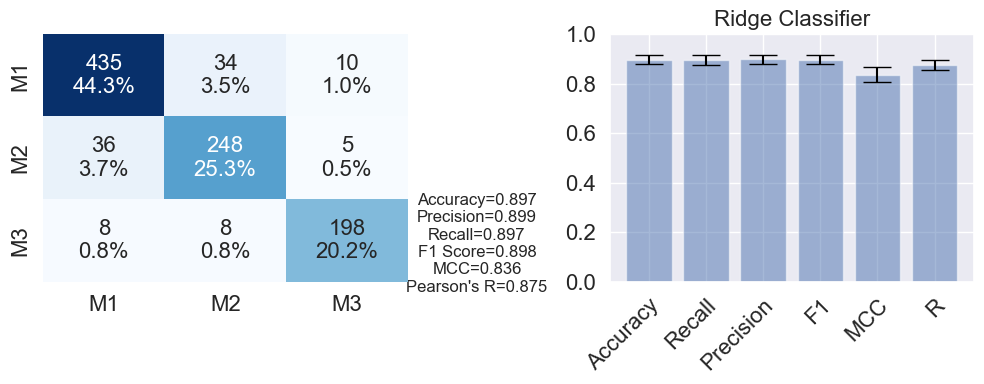

In [28]:
ridge_mdl_all = breastCancerFunctions.tuneModels(X=T_disc_all[all_genes_overlap],
                                         y=T_disc_all['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="DiscoveryAllGenes",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=False,
                                         weight=True)


Creation of the directory ./notebook_figures//validation failed

 Ridge_allGenes 

NO SCALING!


<Figure size 640x480 with 0 Axes>

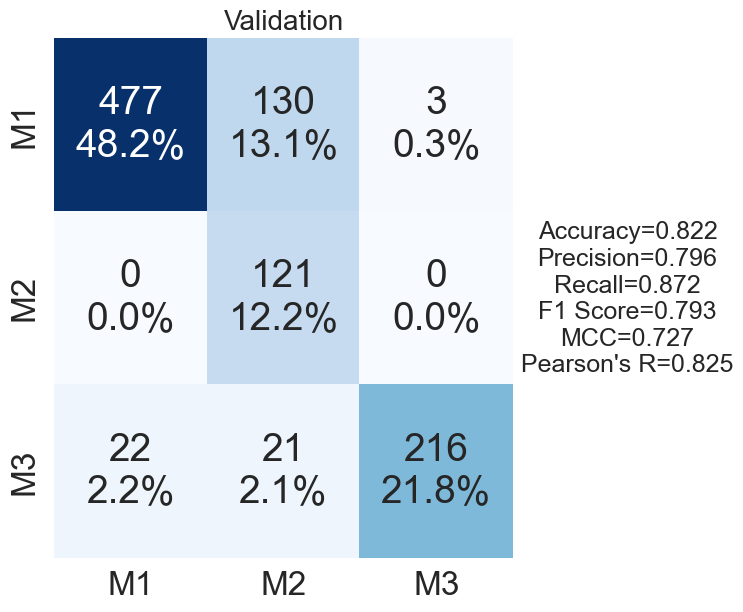

NO SCALING!


<Figure size 640x480 with 0 Axes>

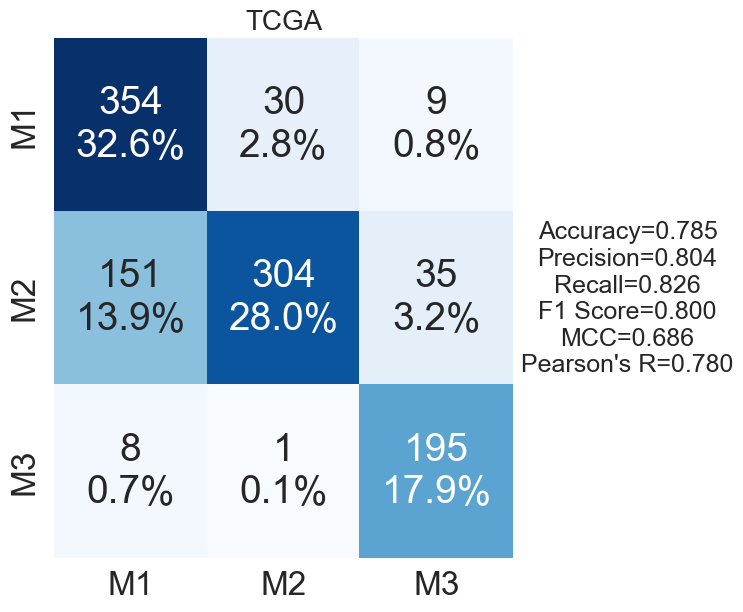

In [29]:
ridge_validate_allGenes = breastCancerFunctions.modelValidation(ridge_mdl_all,
                X_vals=[T_val_all[all_genes_overlap], T_tcga_all[all_genes_overlap]],
                y_vals=[T_val_all['Metabolic cluster'], T_tcga_all['Metabolic cluster']],
                val_IDs=["Validation","TCGA"],
                condition="Ridge_allGenes",
                class_names=class_names,
                path=val_path,
                scale="none")

### Train and validate model on all non-metabolic genes

Creation of the directory ./notebook_figures/tuneModels failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!


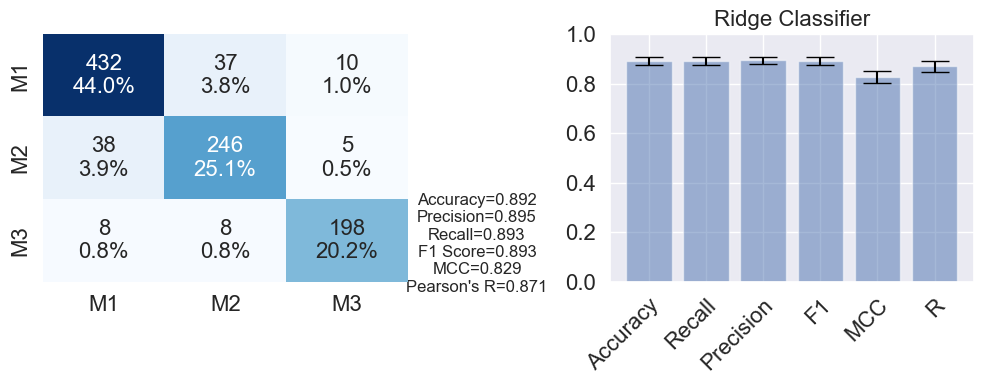

Creation of the directory ./notebook_figures//validation failed

 Ridge_nonMetabGenes 

NO SCALING!


<Figure size 640x480 with 0 Axes>

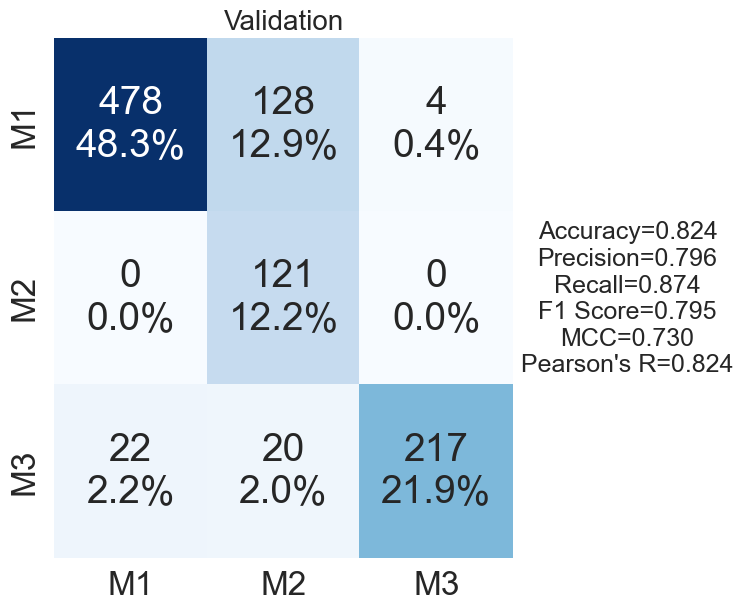

NO SCALING!


<Figure size 640x480 with 0 Axes>

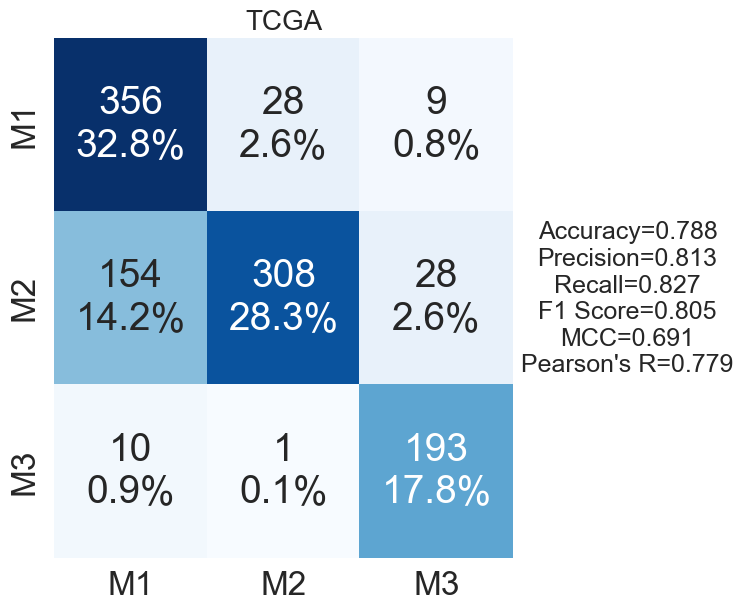

In [30]:
genes_no_metab = list(set(all_genes_overlap) - set(matching_genes))

ridge_mdl_allNonMetab = breastCancerFunctions.tuneModels(X=T_disc_all[genes_no_metab],
                                         y=T_disc_all['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="DiscoveryNonMetabGenes",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=False,
                                         weight=True)

ridge_validate_allNonMetab = breastCancerFunctions.modelValidation(ridge_mdl_allNonMetab,
                X_vals=[T_val_all[genes_no_metab], T_tcga_all[genes_no_metab]],
                y_vals=[T_val_all['Metabolic cluster'], T_tcga_all['Metabolic cluster']],
                val_IDs=["Validation","TCGA"],
                condition="Ridge_nonMetabGenes",
                class_names=class_names,
                path=val_path,
                scale="none")

### What about a random set of 1,330 non-metabolic genes (same # as in our metabolic dataset)?

Creation of the directory ./notebook_figures/tuneModels failed
TRAINING Ridge MODEL
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!
NO FEATURE SCALING!
NO HP TUNING!


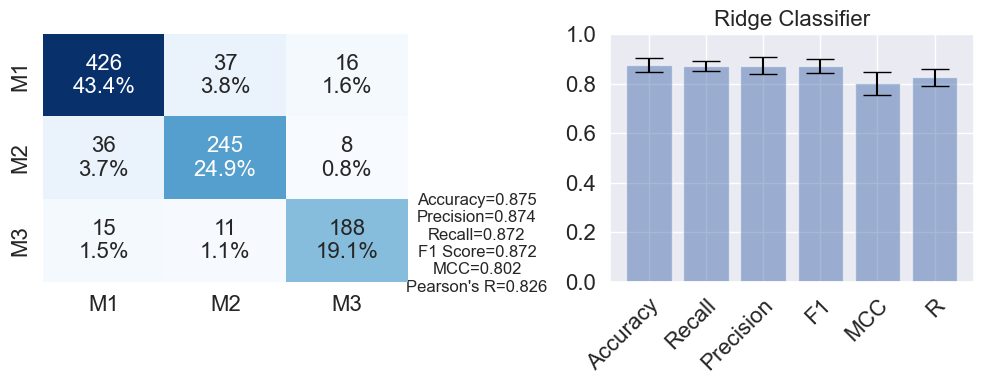

Creation of the directory ./notebook_figures//validation failed

 Ridge_randGenes 

NO SCALING!


<Figure size 640x480 with 0 Axes>

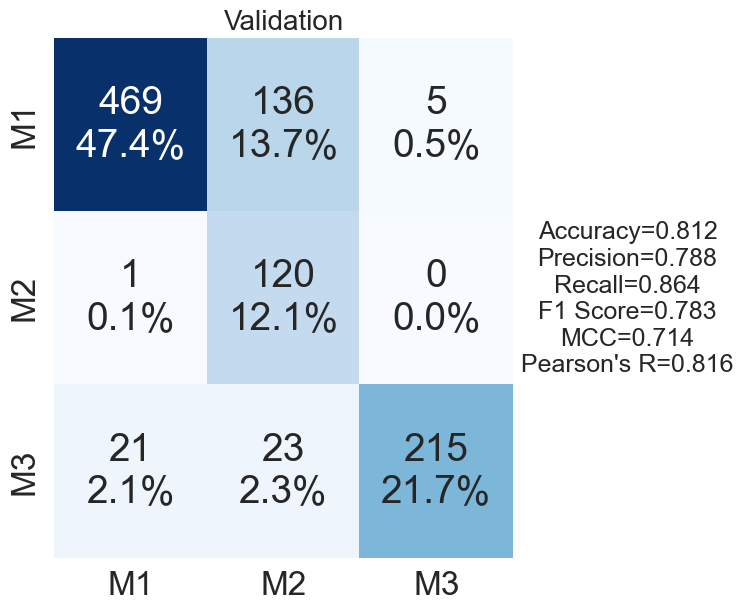

NO SCALING!


<Figure size 640x480 with 0 Axes>

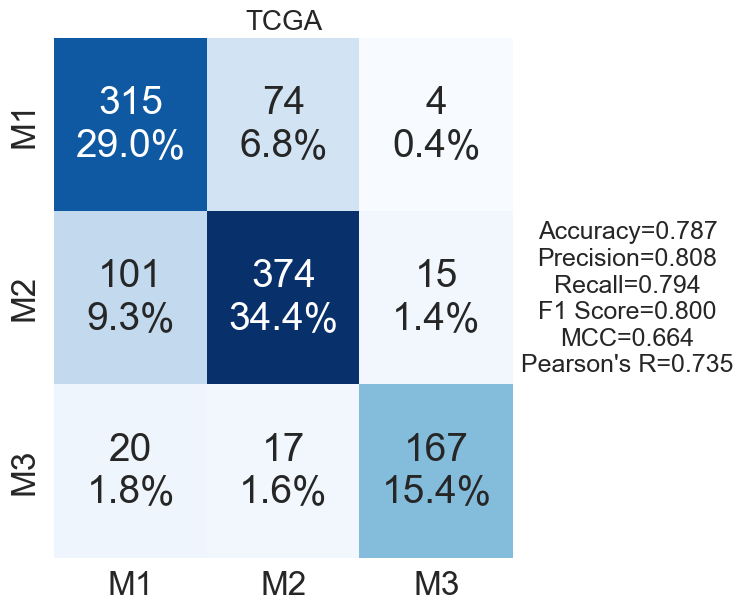

In [33]:
from random import sample
rand_genes = sample(genes_no_metab, len(matching_genes))

ridge_mdl_allRandGenes = breastCancerFunctions.tuneModels(X=T_disc_all[rand_genes],
                                         y=T_disc_all['Metabolic cluster'],
                                         model_name = "Ridge",
                                         condition="DiscoveryRandGenes",
                                         path=tune_mdls_path,
                                         class_names = class_names,
                                         scale = "none",
                                         tune=False,
                                         weight=True)

ridge_validate_allNonMetab = breastCancerFunctions.modelValidation(ridge_mdl_allRandGenes,
                X_vals=[T_val_all[rand_genes], T_tcga_all[rand_genes]],
                y_vals=[T_val_all['Metabolic cluster'], T_tcga_all['Metabolic cluster']],
                val_IDs=["Validation","TCGA"],
                condition="Ridge_randGenes",
                class_names=class_names,
                path=val_path,
                scale="none")

In [35]:
len(genes_no_metab)

16389